**Input:** </br>
df_icu, </br>
df_feats_clinical,</br>
df_master_preprocessed</br>
**Output:** </br>
feats_icu </br>

In [2]:
from utilities import *

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df_icu = pd.read_csv('/drives/drive2/Patient Safety Graph/Data/data_release_12132022/ICU_STAY_20221128.csv', sep=',', encoding="utf-8")

In [5]:
#some location has multiple type, so we just combine them
df_icu['ON_HOSP_ORG_LVL4_DESC'] = df_icu['ON_HOSP_ORG_LVL4_DESC'] + "_" + df_icu['ON_BED_TYPE']

In [6]:
df_feats_clinical=pickle.load(open('/drives/drive1/home/changyu_yin/Desktop/PSG/PSG_AMIA_NEJM/feature/df_feats_clinical.pkl','rb'))
df_master_preprocessed=pickle.load(open('/drives/drive1/home/changyu_yin/Desktop/PSG/PSG_AMIA_NEJM/intermediary/df_master_preprocessed.pkl','rb'))

In [7]:
hospenc_index_all = df_feats_clinical['ENCRYPTED_HOSP_ENCOUNTER'].drop_duplicates().values

# subgraph for manuscript

In [8]:
df_icu_size = df_icu.groupby('ENCRYPTED_HOSP_ENCOUNTER').size().reset_index()
df_icu_size.columns = ['ENCRYPTED_HOSP_ENCOUNTER','count']
df_icu_size.sort_values('count',ascending = False)
df_icu_interested = df_icu_size.sort_values('count',ascending = False).reset_index(drop=True)['ENCRYPTED_HOSP_ENCOUNTER'].values

{'UF NTOR_ACUTE', 'UF NTOR_INTERMEDIATE', 'UF GI ENDOSCOPY_ACUTE', 'UF NT2425_ACUTE', 'UF UAED_ACUTE', 'UF GI ENDOSCOPY_INTERMEDIATE', 'UF NTOR_INTENSIVE', 'UF NT2425_INTENSIVE', 'UF 72BI_INTENSIVE', 'UF NT2425_INTERMEDIATE'}
         ON_HOSP_ORG_LVL4_DESC   ON_BED_TYPE
373319           UF UAED_ACUTE         ACUTE
373318       UF 72BI_INTENSIVE     INTENSIVE
373317       UF NTOR_INTENSIVE     INTENSIVE
373316       UF 72BI_INTENSIVE     INTENSIVE
373315       UF NTOR_INTENSIVE     INTENSIVE
...                        ...           ...
373380  UF NT2425_INTERMEDIATE  INTERMEDIATE
373379         UF NT2425_ACUTE         ACUTE
373378           UF NTOR_ACUTE         ACUTE
373377         UF NT2425_ACUTE         ACUTE
373376   UF GI ENDOSCOPY_ACUTE         ACUTE

[82 rows x 2 columns]
{'UF UAED_ACUTE': {'BED_TYPE': 'ACUTE'}, 'UF 72BI_INTENSIVE': {'BED_TYPE': 'INTENSIVE'}, 'UF NTOR_INTENSIVE': {'BED_TYPE': 'INTENSIVE'}, 'UF NT2425_INTENSIVE': {'BED_TYPE': 'INTENSIVE'}, 'UF NT2425_INTERMEDIATE'

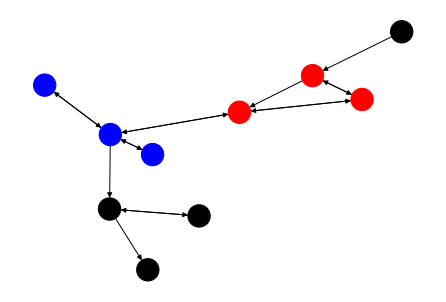

In [31]:
hosp_case_id = df_icu_interested[1]

identify_time = df_master_preprocessed['Surgery_End_Datetime'][df_master_preprocessed['ENCRYPTED_HOSP_ENCOUNTER'] == hosp_case_id].values[0]

subset_encounter_icu = df_icu[df_icu['ENCRYPTED_HOSP_ENCOUNTER'] == hosp_case_id].drop_duplicates()
subset_encounter_icu['ENTER_DT'] = pd.to_datetime(subset_encounter_icu['ENTER_DT'])
subset_encounter_icu_sorted = subset_encounter_icu.sort_values(by=['ENTER_DT'])
subset_encounter_icu_clean = subset_encounter_icu_sorted[subset_encounter_icu_sorted['ENTER_DT'] < identify_time]

#icu stay graph
nodes = list(subset_encounter_icu_clean['ON_HOSP_ORG_LVL4_DESC'])

association = subset_encounter_icu_clean['ON_HOSP_ORG_LVL4_DESC'].values.tolist()

Patient_level_icu_transfer_graph = nx.DiGraph()

for idx in range(len(association)-1):
    Patient_level_icu_transfer_graph.add_edge(association[idx], association[idx+1], weight=1)   


# #### Node, Edge, Attribute Creation
nodes_type = subset_encounter_icu_clean[['ON_HOSP_ORG_LVL4_DESC','ON_BED_TYPE']]
print(set(nodes))
print(nodes_type)

attrs_all = dict() 

for values in list(nodes_type.values):
    node_id_all = values[0]
    specialty_all = values[1] 
    attrs_all[node_id_all] = {"BED_TYPE":specialty_all}
print(attrs_all)  
nx.set_node_attributes(Patient_level_icu_transfer_graph, attrs_all)

color_state_map = {'ACUTE': 'black', 'INTENSIVE': 'red', 'INTERMEDIATE': 'blue'}

nx.draw(Patient_level_icu_transfer_graph,
verticalalignment='top', 
node_size=500,
with_labels=False,
node_color=[color_state_map[node[1]['BED_TYPE']] 
        for node in Patient_level_icu_transfer_graph.nodes(data=True)], 
font_color='white',
font_size = 10)


{'UF NTOR_ACUTE', 'UF NTOR_INTENSIVE', 'UF UAOR_ACUTE', 'UF UA6E_ACUTE'}
       ON_HOSP_ORG_LVL4_DESC ON_BED_TYPE
355321         UF UAOR_ACUTE       ACUTE
355320         UF UA6E_ACUTE       ACUTE
355319         UF UAOR_ACUTE       ACUTE
355332         UF UA6E_ACUTE       ACUTE
355331         UF UAOR_ACUTE       ACUTE
355330         UF UA6E_ACUTE       ACUTE
355329         UF UAOR_ACUTE       ACUTE
355328         UF UA6E_ACUTE       ACUTE
355327         UF UAOR_ACUTE       ACUTE
355326         UF UA6E_ACUTE       ACUTE
355325         UF NTOR_ACUTE       ACUTE
355324     UF NTOR_INTENSIVE   INTENSIVE
{'UF UAOR_ACUTE': {'BED_TYPE': 'ACUTE'}, 'UF UA6E_ACUTE': {'BED_TYPE': 'ACUTE'}, 'UF NTOR_ACUTE': {'BED_TYPE': 'ACUTE'}, 'UF NTOR_INTENSIVE': {'BED_TYPE': 'INTENSIVE'}}


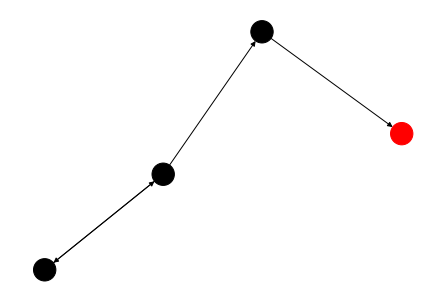

In [30]:
hosp_case_id = df_icu_interested[500]

identify_time = df_master_preprocessed['Surgery_End_Datetime'][df_master_preprocessed['ENCRYPTED_HOSP_ENCOUNTER'] == hosp_case_id].values[0]

subset_encounter_icu = df_icu[df_icu['ENCRYPTED_HOSP_ENCOUNTER'] == hosp_case_id].drop_duplicates()
subset_encounter_icu['ENTER_DT'] = pd.to_datetime(subset_encounter_icu['ENTER_DT'])
subset_encounter_icu_sorted = subset_encounter_icu.sort_values(by=['ENTER_DT'])
subset_encounter_icu_clean = subset_encounter_icu_sorted[subset_encounter_icu_sorted['ENTER_DT'] < identify_time]

#icu stay graph
nodes = list(subset_encounter_icu_clean['ON_HOSP_ORG_LVL4_DESC'])

association = subset_encounter_icu_clean['ON_HOSP_ORG_LVL4_DESC'].values.tolist()

Patient_level_icu_transfer_graph = nx.DiGraph()

for idx in range(len(association)-1):
    Patient_level_icu_transfer_graph.add_edge(association[idx], association[idx+1], weight=1)   


# #### Node, Edge, Attribute Creation
nodes_type = subset_encounter_icu_clean[['ON_HOSP_ORG_LVL4_DESC','ON_BED_TYPE']]
print(set(nodes))
print(nodes_type)

attrs_all = dict() 

for values in list(nodes_type.values):
    node_id_all = values[0]
    specialty_all = values[1] 
    attrs_all[node_id_all] = {"BED_TYPE":specialty_all}
print(attrs_all)  
nx.set_node_attributes(Patient_level_icu_transfer_graph, attrs_all)

color_state_map = {'ACUTE': 'black', 'INTENSIVE': 'red', 'INTERMEDIATE': 'blue'}

nx.draw(Patient_level_icu_transfer_graph,
verticalalignment='top', 
node_size=500,
with_labels=False,
node_color=[color_state_map[node[1]['BED_TYPE']] 
        for node in Patient_level_icu_transfer_graph.nodes(data=True)], 
font_color='white',
font_size = 10)


# pre-OR ICU

In [23]:
time_variable = ["Room Start Datetime", 
                  "Induction Datetime", 
                  "Incision Datetime", 
                  "Dressing Datetime", 
                  "Emergence Datetime", 
                  "Room End Datetime"]

In [24]:
df_master_preprocessed.Surgery_End_Datetime.isna().sum()

0

In [25]:
hospenc_id = []
icu_graph_features = []
for hosp_case_id in tqdm(hospenc_index_all):
  if np.isin(hosp_case_id,df_icu['ENCRYPTED_HOSP_ENCOUNTER'].values)*1==0:
        hospenc_id.append(hosp_case_id)
        icu_graph_features.append([0,0,0,0,0,0,0,0,0,0,0,0,0])
        continue
        
  #all icu interactions before the end of the last surgery
  identify_time = df_master_preprocessed['Surgery_End_Datetime'][df_master_preprocessed['ENCRYPTED_HOSP_ENCOUNTER'] == hosp_case_id].values[0]
        
  subset_encounter_icu = df_icu[df_icu['ENCRYPTED_HOSP_ENCOUNTER'] == hosp_case_id].drop_duplicates()
  subset_encounter_icu['ENTER_DT'] = pd.to_datetime(subset_encounter_icu['ENTER_DT'])
  subset_encounter_icu_sorted = subset_encounter_icu.sort_values(by=['ENTER_DT'])
  subset_encounter_icu_clean = subset_encounter_icu_sorted[subset_encounter_icu_sorted['ENTER_DT'] < identify_time]

  #icu stay graph
  nodes = set(subset_encounter_icu_clean['ON_HOSP_ORG_LVL4_DESC'])

  association = subset_encounter_icu_clean['ON_HOSP_ORG_LVL4_DESC'].values.tolist()

  Patient_level_icu_transfer_graph = nx.DiGraph()

  for idx in range(len(association)-1):
    if(Patient_level_icu_transfer_graph.has_edge(association[idx], association[idx+1])):
        Patient_level_icu_transfer_graph[association[idx]][association[idx+1]]['weight'] =1+ Patient_level_icu_transfer_graph[association[idx]][association[idx+1]]['weight']
    else :
        Patient_level_icu_transfer_graph.add_edge(association[idx], association[idx+1], weight=1)

  num_edges_weighted = Patient_level_icu_transfer_graph.size(weight='weight')
  num_nodes = nx.number_of_nodes(Patient_level_icu_transfer_graph)
  density_g = 0
  if num_nodes>1:
    density_g=num_edges_weighted/(num_nodes*(num_nodes-1))

  ind_g = Patient_level_icu_transfer_graph.in_degree(weight='weight')
  ind_g = [tup[1] for tup in ind_g]
    
  ond_g = Patient_level_icu_transfer_graph.out_degree(weight='weight')
  ond_g = [tup[1] for tup in ond_g]

  ind_list = fill_empty_list(list(ind_g))
  ond_list = fill_empty_list(list(ond_g))

  # the non-normalized features
  graph_info_list = [num_nodes, num_edges_weighted, density_g]

  metric_features = agg_sta_featues_icu(ind_list) + agg_sta_featues_icu(ond_list) + graph_info_list #+ agg_sta_featues(bwt_list) + agg_sta_featues(cls_list)
  
  hospenc_id.append(hosp_case_id)
  icu_graph_features.append(metric_features)


100%|████████████████████████████████| 136647/136647 [88:30:09<00:00,  2.33s/it]


In [26]:
hospenc_enc_indx = pd.DataFrame(hospenc_id,columns=["ENCRYPTED_HOSP_ENCOUNTER"])
df_icu_graph_features = pd.DataFrame(icu_graph_features,columns=['icu_ind_mean',
                                              'icu_ind_median',
                                              'icu_ind_iqr',
                                              'icu_ind_min',
                                             'icu_ind_max',
                                             'icu_ond_mean',
                                              'icu_ond_median',
                                              'icu_ond_iqr',
                                              'icu_ond_min',
                                             'icu_ond_max',
                                             'icu_node',
                                             'icu_edge',
                                             'icu_density'])
df_icu_graph_features = pd.concat([hospenc_enc_indx,df_icu_graph_features],axis=1)

df_icu_graph_features = pd.merge(df_feats_clinical[['ENCRYPTED_HOSP_ENCOUNTER']],df_icu_graph_features,on='ENCRYPTED_HOSP_ENCOUNTER',how='left').fillna(0)

# pre-OR ICU LOS

In [11]:
df_icu = df_icu[df_icu['ENCRYPTED_HOSP_ENCOUNTER'].isin(hospenc_index_all)]

In [15]:
df_icu = df_icu[['ENCRYPTED_HOSP_ENCOUNTER','ON_BED_TYPE','TIME_IN_MINUTES']]
df_icu.columns = ['ENCRYPTED_HOSP_ENCOUNTER','ON_BED_TYPE','PreORLOS']

In [22]:
df_icu = df_icu.groupby(['ENCRYPTED_HOSP_ENCOUNTER','ON_BED_TYPE']).sum()
df_icu = df_icu.reset_index()
df_icu['PreORLOS'] = df_icu['PreORLOS']/60 

In [37]:
df_icu = df_icu.pivot(columns="ON_BED_TYPE",index="ENCRYPTED_HOSP_ENCOUNTER",values="PreORLOS").fillna(0).reset_index()

In [56]:
df_icu = df_feats_clinical[['ENCRYPTED_HOSP_ENCOUNTER']].merge(df_icu,on='ENCRYPTED_HOSP_ENCOUNTER',how='left').fillna(0)

In [57]:
len(df_icu['ENCRYPTED_HOSP_ENCOUNTER']),len(set(df_icu['ENCRYPTED_HOSP_ENCOUNTER']))

(136647, 136647)

# write

In [27]:
#pickle.dump(df_icu_graph_features,open('/drives/drive1/home/changyu_yin/Desktop/PSG/PSG_AMIA_NEJM/feature/df_icu_graph_features.pkl','wb'))
pickle.dump(df_icu_graph_features,open('/drives/drive1/home/changyu_yin/Desktop/PSG/PSG_AMIA_NEJM/feature/df_preORicu_graph_features.pkl','wb'))

In [58]:
pickle.dump(df_icu,open('/drives/drive1/home/changyu_yin/Desktop/PSG/PSG_AMIA_NEJM/feature/df_preor_ICULOS.pkl','wb'))

In [28]:
df_icu_graph_features.shape

(136647, 14)